Cifar-10 Image distribution

In [1]:
import torch
import numpy as np
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
from lib import forward_diffusion, reverse_diffusion, DDPM, make_schedule
#from segmentation_models_pytorch import Unet
from unet import UNetModel
from torchvision.transforms import ToTensor, Compose, PILToTensor, Normalize
import os

In [2]:
#Download Cifar10
#cifar10_dataset_root = '/mimer/NOBACKUP/groups/azizpour-group-alvis/bharath/datasets/cifar10'
#cifar10_dataset = CIFAR10(root=cifar10_dataset_root, download=True)

N=50000 train samples in cifar10


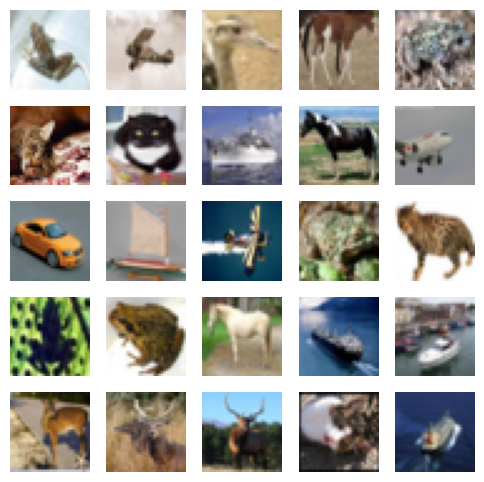

In [3]:
#Visualize Cifar10 images
cifar10_dataset_root = '/mimer/NOBACKUP/groups/azizpour-group-alvis/bharath/datasets/cifar10'
cifar10_train_dataset_orig = CIFAR10(root=cifar10_dataset_root, download=False, train=True)
N = len(cifar10_train_dataset_orig)
print(f"N={N} train samples in cifar10")
num_samples = 25
h, w = int(np.sqrt(num_samples)), int(np.sqrt(num_samples))
assert h*w == num_samples
f, ax = plt.subplots(ncols=w, nrows=h, figsize=(1.2*w,1.2*h))
samples = np.random.choice(np.arange(N),size=num_samples)
for id, sample in enumerate(samples):
    (image, target) = cifar10_train_dataset_orig[sample]
    image = np.array(image)
    r = id//w
    c = id - (r*w)
    ax[r,c].imshow(image)
    ax[r,c].axis('off')

Text(0.5, 0, 'rvar')

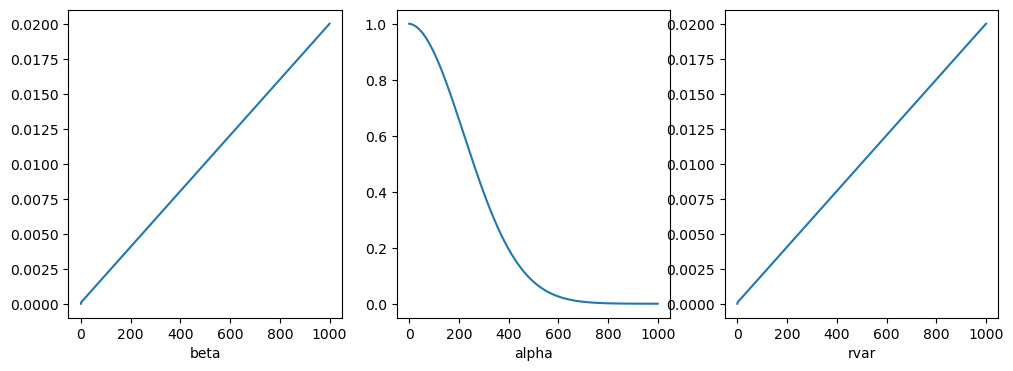

In [4]:
T = 1000
schedule = make_schedule(scheme='linear', rvar='beta', T=T, start_beta=1e-4, end_beta=0.02)
f, ax = plt.subplots(ncols=3,figsize=(12,4))
ax[0].plot(np.arange(start=0,stop=T+1),schedule['beta'])
ax[0].set_xlabel('beta')
ax[1].plot(np.arange(start=0,stop=T+1),schedule['alpha'])
ax[1].set_xlabel('alpha')
ax[2].plot(np.arange(start=0,stop=T+1),schedule['rvar'])
ax[2].set_xlabel('rvar')
#print(schedule['alpha'])

In [5]:
class unet_cifar10(torch.nn.Module):
    def __init__(self, ):
        super().__init__()    
        self.model = Unet(encoder_name="resnet152", encoder_depth=4, decoder_use_batchnorm=False, encoder_weights=None, decoder_channels=[256,64,32,16], in_channels=4, classes=3)
    
    def forward(self, x, t):
        #append time to x and pass x_t to model
        _,_,h,w = x.shape
        t_expanded = (t/T).view((-1,1,1,1)).expand(-1,1,h,w)  #expand to [batch, 1, H, W] like x
        #x_t = x + t_expanded
        x_t = torch.cat((x,t_expanded),1)
        return self.model(x_t)

class unet_cifar10_classic(torch.nn.Module):
    
    def __init__(self,):
        super().__init__()
        self.model = UNetModel(image_size=32,
                            in_channels=3,
                            model_channels=64,
                            out_channels=3,
                            num_res_blocks=2,
                            attention_resolutions=[],
                            dropout=0.1,
                            channel_mult=(1, 2, 2, 2),
                            conv_resample=True,
                            dims=2,
                            num_classes=None,
                            use_checkpoint=False,
                            use_fp16=False,
                            num_heads=1,
                            num_head_channels=-1,
                            num_heads_upsample=-1,
                            use_scale_shift_norm=False,
                            resblock_updown=False,
                            use_new_attention_order=False)

    def forward(self, x, t):
        return self.model(x, t)


if torch.cuda.is_available():
    cuda = True
    os.environ["CUDA_VISIBLE_DEVICES"]="0"
else:
    cuda = False
print(f"cuda is {cuda}, CUDA_VISIBLE_DEVICES={os.environ['CUDA_VISIBLE_DEVICES']}")
model = unet_cifar10_classic()
ddpm_model = DDPM(schedule=schedule,model=model,weightedloss=False,cuda=cuda)

cuda is True, CUDA_VISIBLE_DEVICES=0


In [6]:
optimizer = torch.optim.Adam(ddpm_model.model.parameters(),lr=2e-4)
num_epochs = 30
batch_size = 64
#,Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
cifar10_train_dataset = CIFAR10(root=cifar10_dataset_root, download=False, train=True, transform=Compose([ToTensor(), Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])  ]))
dataloader = torch.utils.data.DataLoader(cifar10_train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(1,num_epochs+1):
    LOSS = 0
    ITER = 0
    for data in dataloader:
        data_x, data_y = data
        optimizer.zero_grad()
        loss = ddpm_model.run_step(data_x)
        loss.backward()
        optimizer.step()
        LOSS += loss.item()
        ITER += 1
    print(f"epoch = {epoch}, loss = {LOSS/ITER}")  
    if epoch % 2 == 0:
        D = {'model_state_dict': ddpm_model.model.state_dict(),
             'optimizer_state_dict': optimizer.state_dict(),
             'epoch': epoch }
        torch.save(D,'ckpts/1bmodel-'+str(epoch)+'.ckpt')  

epoch = 1, loss = 0.08600982283825612
epoch = 2, loss = 0.03821042575694792
epoch = 3, loss = 0.036631536467567734


In [7]:
num_samples = 4
z = np.random.normal(loc=0, scale=1.0, size=(num_samples,3,32,32))
pred_samples = []
for sample_id in range(len(z)):
    x = z[sample_id]
    for t in range(0,T):
        x = reverse_diffusion(ddpm_model=ddpm_model, x=x, t_curr=T-t, cuda=cuda, schedule=schedule, onlymean=False)
        #assert x.shape == (2,)
    pred_samples.append(x)
pred_samples = np.stack(pred_samples,axis=0)
assert pred_samples.shape == z.shape

/mimer/NOBACKUP/groups/azizpour-group-alvis/bharath/research/ddpm_base/lib.py:50: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343964576/work/torch/csrc/utils/tensor_new.cpp:245.)
  x_inp = torch.Tensor([x])


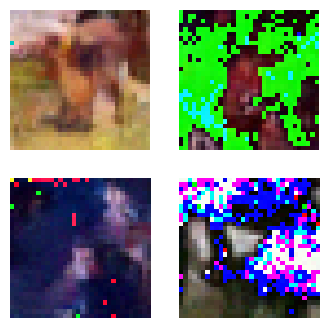

In [8]:
from PIL import Image
h, w = int(np.sqrt(num_samples)), int(np.sqrt(num_samples))
assert h*w == num_samples
f, ax = plt.subplots(ncols=w, nrows=h, figsize=(2*w,2*h))
#plt.title('predicted CIfar10 image distribution')
for id in range(num_samples):
    image  = pred_samples[id]
    image = np.transpose(image,(1,2,0))
    #image = (1.0 + image)*0.5 
    image = 255*image #np.clip(image, a_min=0, a_max=1.0)
    image = np.asarray(image, dtype=np.uint8)
    r = id//w
    c = id - (r*w)
    ax[r,c].imshow(image)
    ax[r,c].axis('off')

In [10]:
model_state_dict = torch.load('1bmodel-10.ckpt')['model_state_dict']
ddpm_model.model.load_state_dict(model_state_dict)

<All keys matched successfully>

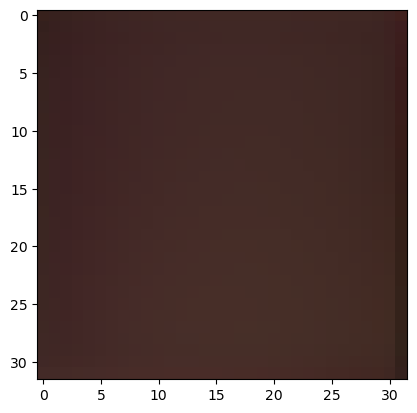

In [14]:
b = pred_samples[1]*255
b = np.asarray(b,dtype=np.uint8)
plt.imshow(np.transpose(b,(1,2,0)))
